In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [142]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


Selection of environments from original distribution


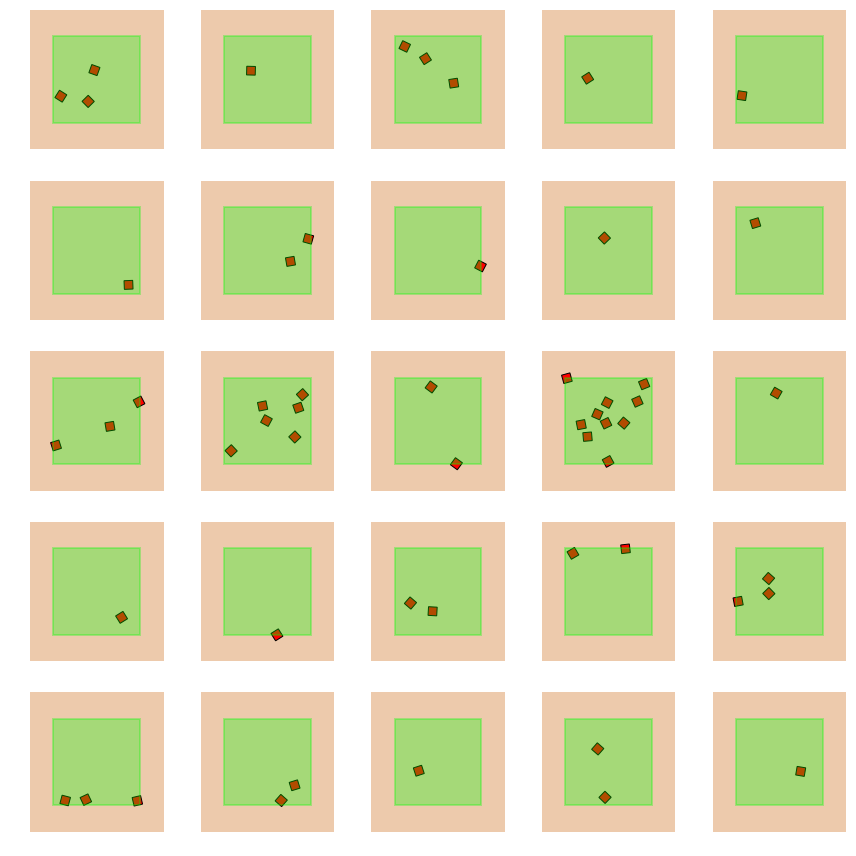

In [143]:
# Illustrate a few example scenes from the training set
import generate_planar_scene_arrangements as psa_utils

def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j], plt.gca())
        plt.grid(True)
plt.tight_layout()

Write our generator in Pyro, as an iterative procedure:

~~~python
keep_going = True
# Spawn the first object with no context -- in our case,
# this is placing a hard-coded ground object.
env = spawn_initial_object()
while (keep_going):
    # Pick an object to spawn
    ci = sample_object_class(env)
    # Pick where to put it
    env = sample_object_placement(ci, env)
    # Make that placement feasible
    env = project_env_to_feasibility(env)
    keep_going = decide_to_continue(env)
~~~

In [318]:
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
#torch.manual_seed(101);

pyro.enable_validation(True)

object_classes = ["small_box"]
object_class_to_index = {}
for i, obj in enumerate(object_classes):
    object_class_to_index[obj] = i
n_object_classes = len(object_classes)


def sample_object_class(n, generated_data, i, keep_going, obs=None):
    # For now, single object class, so this is trivial.
    # Down the road, the category probs will need to depend on env
    # in some way.
    return pyro.sample(
        "%d_class_assignment" % i, dist.Categorical(torch.Tensor([1.0]).expand([n, 1])).mask(keep_going),
        obs=obs)

# Prior distributions for each object class over the ground
class ObjectWorldPriorDescription:
    def __init__(self, ci):
        # parameterized uniform distribution
        self.bound_center = pyro.sample('c%d_center' % ci, dist.Normal(0.5, 0.25).expand([3]).to_event(1))
        self.bound_halfwidth = pyro.sample('c%d_halfwidth' % ci, dist.LogNormal(0.5, 0.25).expand([3]).to_event(1))

def sample_object_placement(n, ci, generated_data, i, keep_going, object_world_prior_params, obs=None):
    # TODO: figure out how to do a broadcast-select of this.
    # I could use index_select if I stacked the params into a Tensor,
    # I just need to abandon my nice data structure...
    prior_info = object_world_prior_params[0]

    location = pyro.sample('location_%d' % (i),
        #using uniform leads to infinite losses later on, due to
        #some observations having zero support
        #dist.Uniform((prior_info.bound_center - prior_info.bound_halfwidth).expand([n, 3]),
        #             (prior_info.bound_center + prior_info.bound_halfwidth).expand([n, 3])).to_event(1).mask(keep_going),
        dist.Normal(prior_info.bound_center.expand([n, 3]),
                    prior_info.bound_halfwidth.expand([n, 3])).to_event(1).mask(keep_going),
        obs=obs)

    return location

MAX_NUM_OBJECTS = 10    
def sample_keep_going(n, generated_data, i, falloff_rate, obs=None):
    return pyro.sample('keep_going_%d' % i,
                        dist.Bernoulli(falloff_rate.expand(n)),
                        obs=obs)

VectorizedEnvironments = namedtuple("VectorizedEnvironments",
    ["idents", "poses", "present", "n_samples"], verbose=False)
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y theta) and
    # idents (ci) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, MAX_NUM_OBJECTS*3)
    poses[:, :] = 0.
    idents = torch.LongTensor(n_environments, MAX_NUM_OBJECTS)
    idents[:, :] = 0
    present = torch.Tensor(n_environments, MAX_NUM_OBJECTS)
    present[:, :] = 0
    n_samples = torch.Tensor(n_environments)
    n_samples[:] = 0
    for i, env in enumerate(envs):
        n_samples[i] = env["n_objects"]
        for k in range(MAX_NUM_OBJECTS):
            if k < env["n_objects"]:
                obj = env["obj_%04d" % k]
                idents[i, k] = object_class_to_index[obj["class"]]
                poses[i, (k*3):(k*3+3)] = torch.Tensor(obj["pose"])
                present[i, k] = 1
    return VectorizedEnvironments(
        idents=idents, poses=poses,
        present=present, n_samples=n_samples)
    
def devectorize_environments(data):
    if not isinstance(data, VectorizedEnvironments):
        raise ValueError("Expected VectorizedEnvironments input")
    envs = []
    for i in range(data.idents.shape[0]):
        env = {}
        n_objects = 0
        for k in range(data.n_samples[i]):
            obj = {
                "pose": data.poses[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": object_classes[data.idents[i, k].cpu().detach().item()]
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = data.n_samples[i]
        envs.append(env)
    return envs

# Each row of "data" is a vectorized
# description of an environment.
# To make these rows constant size, all vectorizations
# are the same length, but padded with "null objects"
# up to a max number of objects. This is inspired by
# the handling of the Pyro AIR example.

def model(data=None):
    i = 0
    keep_going = True
    
    object_world_prior_params = []
    for i in range(n_object_classes):
        object_world_prior_params.append(
            ObjectWorldPriorDescription(i)
        )
        
    sample_rates = pyro.sample('num_objects_weights', dist.Dirichlet(torch.ones(MAX_NUM_OBJECTS+1)))
    sample_distribution = dist.Categorical(sample_rates)
    
    # Generate in vectorized form for easier batch conversion at the end
    n = 1
    if data:
        if not isinstance(data, VectorizedEnvironments):
            raise ValueError("Expected VectorizedEnvironments input")
        if (data.idents.shape[1] != MAX_NUM_OBJECTS and
           data.poses.shape[1] != MAX_NUM_OBJECTS*3):
            raise ValueError("Got unexpected data shape.")
        n = data.idents.shape[0]
    with pyro.plate('data', n):
        generated_data = VectorizedEnvironments(
            idents=torch.LongTensor(n, MAX_NUM_OBJECTS),
            poses=torch.Tensor(n, MAX_NUM_OBJECTS*3),
            present=torch.Tensor(n, MAX_NUM_OBJECTS),
            n_samples=torch.Tensor(n))
        generated_data.idents[:, :] = -1
        generated_data.poses[:, :] = 0
        generated_data.present[:, :] = 0
        generated_data.n_samples[:] = 0

        # Sample actual number of samples immediately
        gt_n_samples = None
        if data is not None:
            gt_n_samples = data.n_samples
        num_samples = pyro.sample("num_samples", sample_distribution.expand([n]),
                                  obs=gt_n_samples)
        generated_data.n_samples[:] = num_samples
        
        for i in range(MAX_NUM_OBJECTS):
            gt_class = None
            gt_location = None
            gt_keep_going = None
            if data is not None:
                gt_class = data.idents[:, i]
                gt_location = data.poses[:, (i*3):(i*3+3)]
                gt_keep_going = data.present[:, i]
                
            keep_going = (i < num_samples).type(torch.float)
            ci = sample_object_class(n, generated_data, i, keep_going, gt_class)
            location = sample_object_placement(n, ci, generated_data, i, keep_going, object_world_prior_params, gt_location)
            
            # Fill in generated data appropriately
            generated_data.idents[:, i] = ci.view(-1).type(torch.long)*keep_going.type(torch.long)
            for k in range(3):
                generated_data.poses[:, 3*i+k] = torch.Tensor(location[:, k])*keep_going
            generated_data.present[:, i] = keep_going
            # skip feasibility project for first pass
    return generated_data

for k in range(100):
     model()
print model()

VectorizedEnvironments(idents=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), poses=tensor([[-0.2886,  0.8169,  4.0119,  0.3822, -0.1739, -0.1407,  3.2961, -0.3708,
         -1.4957,  3.0330,  1.5230, -1.4654,  2.8141,  0.8003,  2.3521,  0.0000,
          0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]), present=tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]]), n_samples=tensor([5.]))


Selection of environments from prior / generative model


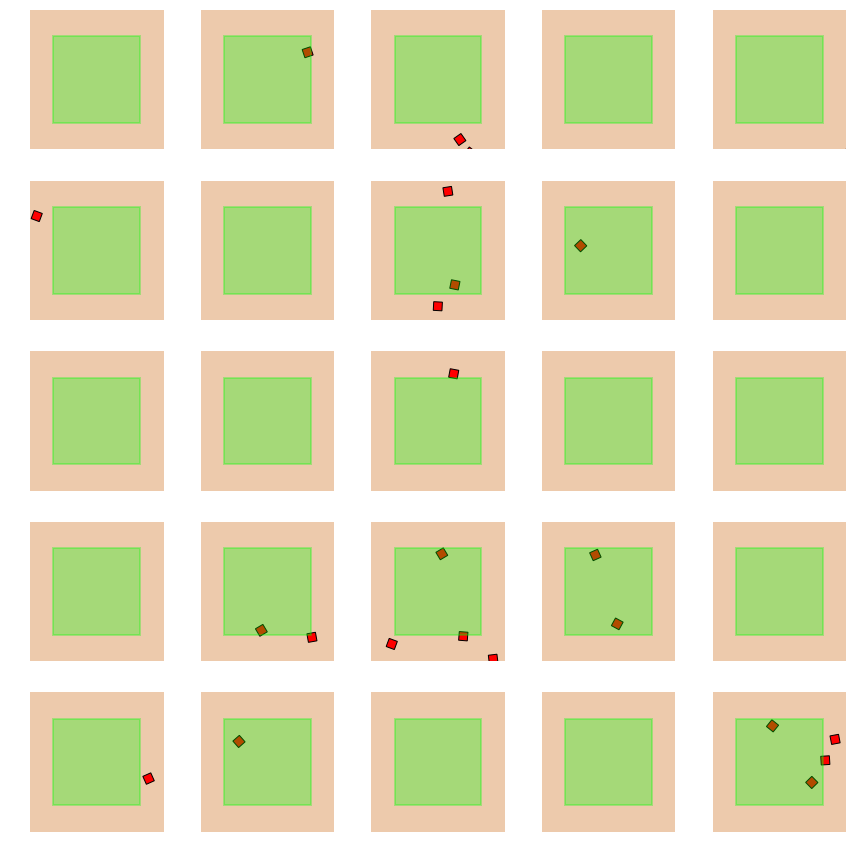

In [319]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(model())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [329]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

global_guide = AutoDelta(
    poutine.block(model, expose=['num_objects_weights', 'c0_center', 'c0_halfwidth']))
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    pyro.param('auto_num_objects_weights', torch.ones(MAX_NUM_OBJECTS+1)/float(MAX_NUM_OBJECTS+1), constraint=constraints.simplex)
    pyro.param('auto_c0_center', torch.Tensor([0.5, 0.5, 1.57]))
    pyro.param('auto_c0_halfwidth', torch.Tensor([1.0, 1.0, 4.0]))

# Choose the best among 100 random initializations.
initialize(42)

losses = []
data = vectorize_environments(environments)
for i in range(200):
    loss = svi.step(data)
    losses.append(loss)
    if (i % 10 == 0):
        print ".",
    if (i % 50 == 0):
        print global_guide.median()
print "Done"

. {'c0_halfwidth': tensor([0.8000, 0.8000, 3.8000], grad_fn=<ExpandBackward>), 'num_objects_weights': tensor([0.0802, 0.1196, 0.1196, 0.1196, 0.0802, 0.0802, 0.0802, 0.0802, 0.0802,
        0.0802, 0.0802], grad_fn=<ExpandBackward>), 'c0_center': tensor([0.3000, 0.7000, 1.7700], grad_fn=<ExpandBackward>)}
. . . . . {'c0_halfwidth': tensor([0.2931, 0.2880, 1.8145], grad_fn=<ExpandBackward>), 'num_objects_weights': tensor([0.0016, 0.5454, 0.2423, 0.1239, 0.0469, 0.0175, 0.0128, 0.0043, 0.0016,
        0.0016, 0.0020], grad_fn=<ExpandBackward>), 'c0_center': tensor([0.4889, 0.5039, 3.0905], grad_fn=<ExpandBackward>)}
. . . . . {'c0_halfwidth': tensor([0.2922, 0.2881, 1.8141], grad_fn=<ExpandBackward>), 'num_objects_weights': tensor([0.0007, 0.5478, 0.2427, 0.1239, 0.0469, 0.0178, 0.0128, 0.0048, 0.0007,
        0.0007, 0.0012], grad_fn=<ExpandBackward>), 'c0_center': tensor([0.4881, 0.5047, 3.0884], grad_fn=<ExpandBackward>)}
. . . . . {'c0_halfwidth': tensor([0.2922, 0.2881, 1.8141], gra

{'c0_halfwidth': tensor([0.2904, 0.2815, 1.8141], grad_fn=<ExpandBackward>), 'num_objects_weights': tensor([2.3118e-04, 5.4866e-01, 2.4291e-01, 1.2397e-01, 4.6974e-02, 1.7955e-02,
        1.2951e-02, 4.9420e-03, 2.3118e-04, 2.3118e-04, 9.3471e-04],
       grad_fn=<ExpandBackward>), 'c0_center': tensor([0.4807, 0.4959, 3.0884], grad_fn=<ExpandBackward>)}


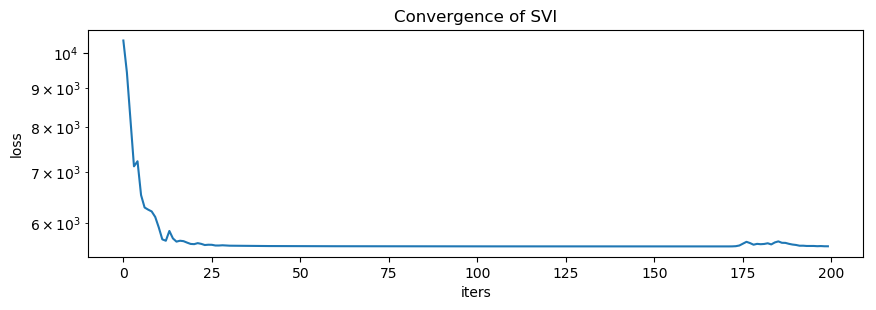

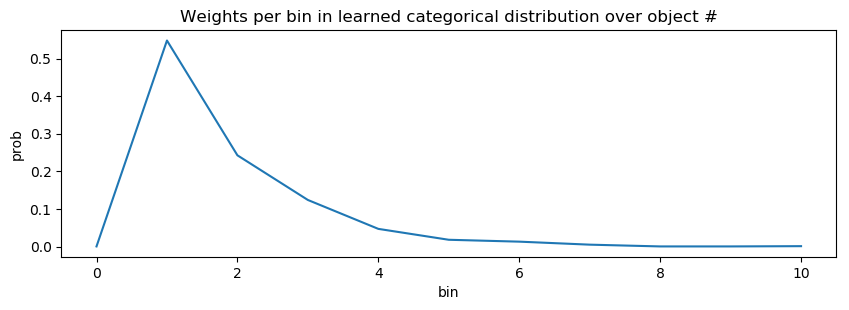

In [333]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
print global_guide.median()

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(global_guide.median()["num_objects_weights"].cpu().detach().numpy())
plt.xlabel('bin')
plt.ylabel('prob')
plt.title('Weights per bin in learned categorical distribution over object #');

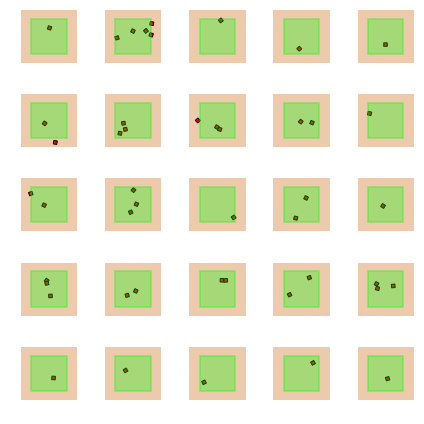

In [331]:
latent_vals = global_guide.sample_latent()
conditioned_model = poutine.condition(model, data=global_guide.median())

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = conditioned_model()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()